# Phantom Generation for UMPIRE Test Cases

Showcase of Phantom Generation for UMPIRE test cases. 2D and semi 3D.

> **Have a look at the imported test-function documentation for detailed information**


In [16]:
# jupyter-notebook extensions
%matplotlib notebook
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

# custom import of built umpire package
from umpire import UMPIRE

# custom manual import of test lib
import sys
sys.path.append("../tests")

from test_umpire import generate_simulated_data_2D, generate_simulated_data_semi3D, wrap_phase

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Some utility functions

In [9]:
def plt_colorbar(figure, axis, data, cmap='plasma'):
    """Appends colorbar to axis and scales it according to data.
    
    Requires the following imports:
    
        import matplotlib.cm as cm
        from mpl_toolkits.axes_grid1 import make_axes_locatable
        
    """
    divider = make_axes_locatable(axis)
    cax = divider.append_axes('right', size='5%', pad=0.05)

    norm = plt.Normalize(np.min(data), np.max(data))
    figure.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), cax=cax, orientation='vertical')

In [171]:
def plot_image_series(arrays, label_list, nrows=1, plot_func=None, **subplot_kwrags):
    """Plots series of images into subplots, optionally into multiple rows"""
    def pad_or_truncate(some_list, target_len):
        return some_list[:target_len] + [""]*(target_len - len(some_list))
    
    ncols = len(arrays) // nrows
    
    if len(label_list) != nrows * ncols:
        label_list = pad_or_truncate(label_list, nrows*ncols)
    
    fig, axs = plt.subplots(ncols=ncols, nrows=nrows, **subplot_kwrags)

    for ax, arr, label in zip(axs.flat, arrays, label_list):
        if plot_func:
            plot_func(ax, arr)
        else:
            ax.imshow(arr, cmap='plasma')
        plt_colorbar(fig, ax, arr)
        ax.axis('off')
        ax.set_title(label)

    fig.tight_layout()

In [153]:
def plot4d(data, **scatter_kwargs):
    """4D plot = 3D colorcoded matrix plot
    
    https://stackoverflow.com/questions/14995610/how-to-make-a-4d-plot-with-matplotlib-using-arbitrary-data
    """
    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(projection="3d")
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False
    mask = data < 1e5
    idx = np.arange(int(np.prod(data.shape)))
    x, y, z = np.unravel_index(idx, data.shape)
    ax.scatter(x, y, z, c=data.flatten(), s=10.0 * mask, edgecolor="face", alpha=0.5, marker="o", cmap="magma", linewidth=0)
    plt.tight_layout()
    return ax

# 2D Phantoms

In [126]:
TEs = [5, 10, 16, 21]
img_dims_2d = (64, 64)

### 01. Generate Phase Images

<IPython.core.display.Javascript object>


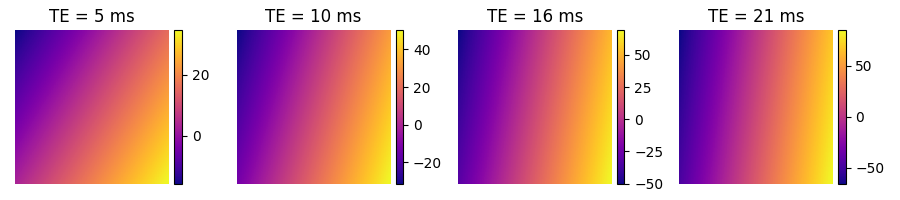

In [127]:
phase_images_2d = generate_simulated_data_2D(img_dims_2d, TEs, reciever_offset=True)

plot_image_series(phase_images_2d, [f"TE = {t} ms" for t in TEs], nrows=1, figsize=(9,2))

### 02. Wrap Phase Images

<IPython.core.display.Javascript object>


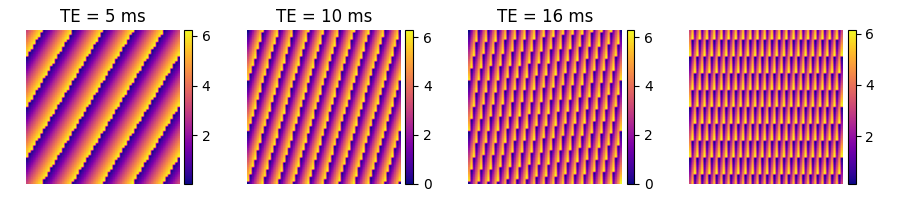

In [170]:
phase_imgs_2d_wrapped = wrap_phase(phase_images_2d)

plot_image_series(phase_imgs_2d_wrapped, [f"TE = {t} ms" for t in TEs], figsize=(9,2))

### 03. Apply UMPIRE and compare with ground truth

Along the edges at exactly $\phi = \pi$ and $\phi=-\pi$ floating point errors lead to false results.  
This is however a very artificial szenario and should be of no concern.

<IPython.core.display.Javascript object>


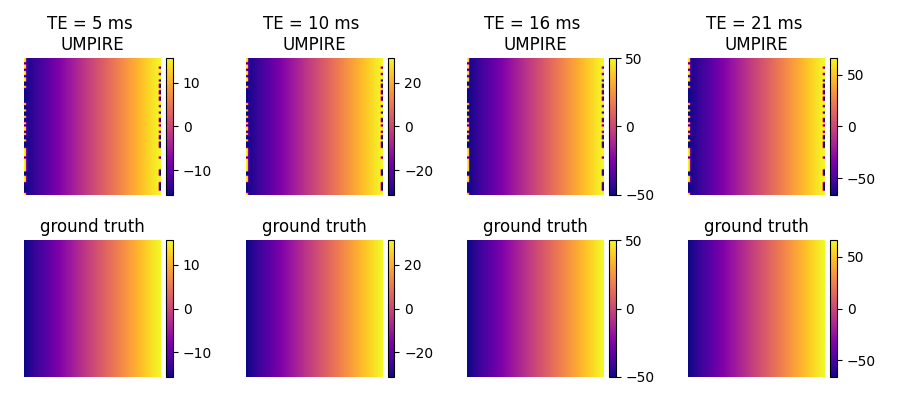

In [135]:
phase_imgs_2d_umpire = UMPIRE(
    phase_imgs_2d_wrapped,
    TEs,
    DPD_filter_func=False,
    magnitude_weighted_omega_star=False,
)

phase_images_2d_groundtruth = generate_simulated_data_2D(img_dims_2d, TEs, reciever_offset=False)

plot_image_series(np.concatenate((phase_imgs_2d_umpire, phase_images_2d_groundtruth)),
                  [f"TE = {t} ms \nUMPIRE" for t in TEs] + ["ground truth"] * 4,
                  nrows=2,
                  plot_func = lambda x,y: x.imshow(y, cmap='plasma'),
                  figsize=(9,4))

# semi3D Phantoms

In [158]:
TEs = [5, 10, 16]
img_dims_3d = (64, 64, 64)

### 01. Generate 3D Phase Images

We ony display the first echo time here.

<IPython.core.display.Javascript object>


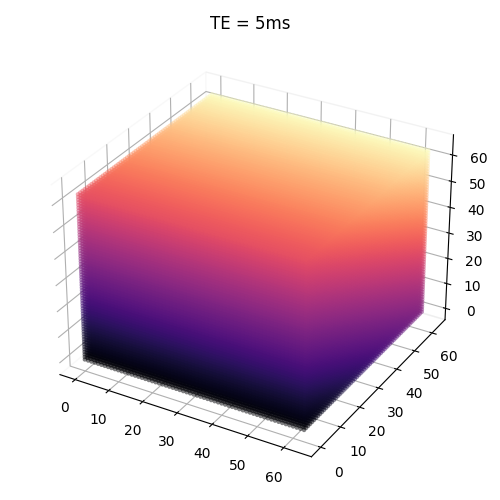

In [163]:
phase_images_3d = generate_simulated_data_semi3D(img_dims_3d, TEs)

ax = plot4d(phase_images_3d[0], label="x")
ax.set_title("TE = 5ms")
plt.tight_layout()

### 02. Wrap the Phase

<IPython.core.display.Javascript object>


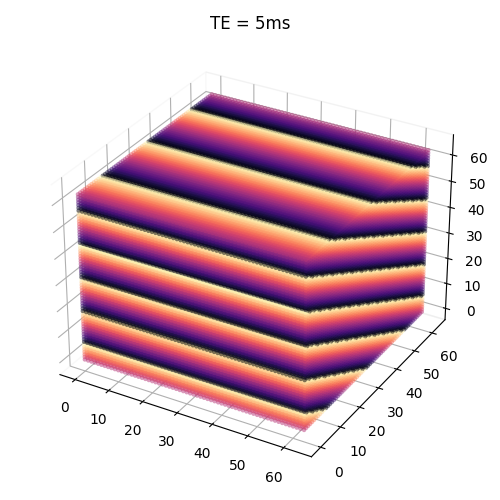

In [164]:
phase_images_3d_wrapped = wrap_phase(phase_images_3d)

ax = plot4d(phase_images_3d_wrapped[0], label="x")
ax.set_title("TE = 5ms")
plt.tight_layout()

### 03. Apply UMPIRE

Along the edges at exactly $\phi = \pi$ and $\phi=-\pi$ floating point errors lead to false results.  
This is however a very artificial szenario and should be of no concern.

<IPython.core.display.Javascript object>


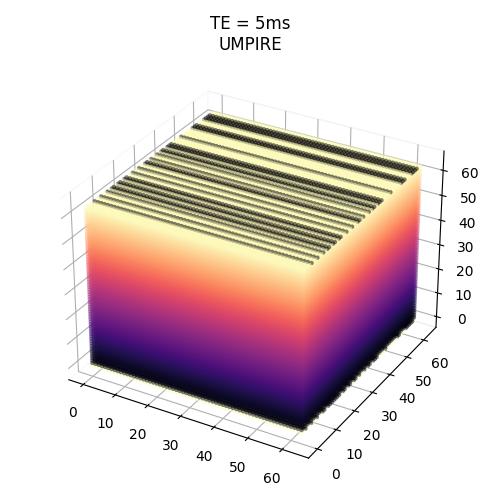

In [168]:
phase_images_3d_umpire = UMPIRE(
    phase_images_3d_wrapped,
    TEs,
    DPD_filter_func=False,
    magnitude_weighted_omega_star=False,
)

ax = plot4d(phase_images_3d_umpire[0], label="x")
ax.set_title("TE = 5ms\nUMPIRE")
plt.tight_layout()